# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape   # 70,000개의 이미지, 각 이미지에는 28*28개의 특성

(70000, 784)

In [6]:
y.shape   # 70,000개의 label

(70000,)

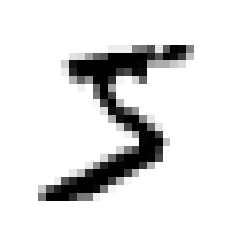

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

some_digit = X.to_numpy()[0]   # X 중 맨 처음 걸로 샘플 하나만 가져와서 확인해보기
some_digit_image = some_digit.reshape(28, 28)   # 샘플의 특성 벡터(784) -> 배열(28*28)로 크기 변경

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
y[0]

'5'

In [13]:
y = y.astype(np.int8)   # 문자열인 label을 정수로 변환

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]   # train set과 test set 나누기

***

# 3.2 이진 분류기 훈련

### 🎯 숫자 5만 식별해보기  
> **classes**
- 5
- 5아님

In [15]:
y_train_5 = (y_train == 5)   # train set의 label들 중 '5'인 것만 True, 나머지는 False
y_test_5 = (y_test == 5)   # test set의 laebel들 중 '5'인 것만 True, 나머지는 False

In [16]:
from sklearn.linear_model import SGDClassifier   # 확률적 경사 하강법, '5' 클래스로 분류하는 분류기

sgd_clf = SGDClassifier(random_state=42)   # random_state: 호출할 때마다 같은 훈련, 테스트 셋을 생성하기 위한 매개변수, 어떤 값이든 상관X, random값을 고정하는 역할만 수행
sgd_clf.fit(X_train, y_train_5)   # X_train과 y_train_5로 SGD 분류기 학습 -> X_train에 대하여 5인 것들만 label값을 True로, 나머지는 False로 학습 

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])   # 위에서 가져온 X[0] 샘플로 예측해보기, True로 알맞게 예측

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

***

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

### 📌 Kfold cross validation

> 1. 훈련셋을 k개의 fold로 나눔
2. iterator가 돌면서 하나는 validation fold로 나머지 k-1개는 training fold로 사용
3. 검증 폴드에 대한 스코어 총 k개 출력
4. k개의 출력값에 대한 평균을 구해 최종 스코어 측정

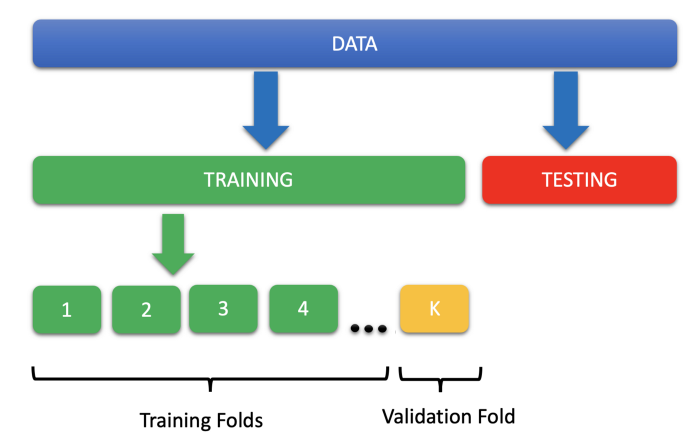
https://miro.medium.com/max/700/1*OIxCD-UoeiHWw_4gffuJRg.gif

In [18]:
from sklearn.model_selection import StratifiedKFold   # 교차 검증 기능 직접 구현해보기
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)   # 데이터셋을 n_splits개의 폴드로 나눔

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.to_numpy()[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.to_numpy()[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
from sklearn.model_selection import cross_val_score   # sklearn의 cross_val_score() 사용하여 위와 같은 작업 수행, 동일한 결과 출력
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")   # '5' 클래스로 분류하는 분류기의 정확도 측정

array([0.95035, 0.96035, 0.9604 ])

✔️ 모든 검증 폴드에 대하여 정확도 95% 이상을 보임  
-> '5'인 클래스를 맞추는 걸 잘함

In [20]:
from sklearn.base import BaseEstimator   # '5 아님' 클래스로 분류하는 분류기

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")   # '5 아님' 클래스로 분류하는 분류기의 정확도 측정

array([0.91125, 0.90855, 0.90915])

✔️ 모든 검증 폴드에 대하여 정확도 90% 이상을 보임  
-> '5 아님' 클래스를 맞추는 걸 잘하는 것 이라고 생각할 수 있지만❗

데이터셋의 10% 정도만 숫자 5여서 모든 이미지에 대해 '5 아님'이라고 예측하면 정확도가 90%  
-> '5'인 클래스(약 10%)보다 '5 아님' 클래스(약 90%)가 월등하게 많은 케이스로 정확도가 성능으로써 큰 의미가 없음   

⭕ 이렇게 **불균형한 데이터셋**을 다룰 때 **정확도는 분류기 성능 지표로 적절하지 않음**

## 3.3.2 오차 행렬

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

✔️ _cross_val_score() != cross_val_predict()_  

`cross_val_score()`  returns **score** of test fold  
`cross_val_predict()` returns **predicted y values** for the test fold

In [23]:
from sklearn.metrics import confusion_matrix   # 오차 행렬 생성
confusion_matrix(y_train_5, y_train_pred)   # '5 아님' 이미지 1,522개를 '5'라고 잘못 분류(거짓 양성, FP), '5' 이미지 1,325개를 '5 아님'으로 잘못 분류(거짓 음성, FN)

array([[53892,   687],
       [ 1891,  3530]])

### 📌 오차 행렬

>`행` 실제 클래스  
`열` 예측한 클래스  

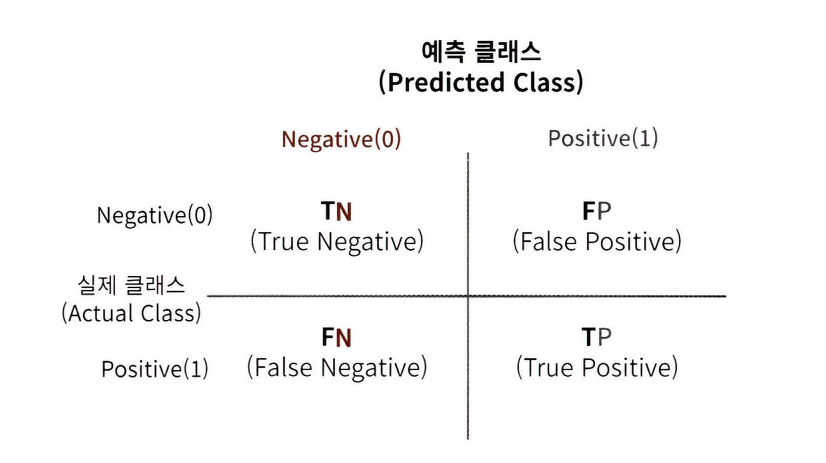

In [24]:
y_train_perfect_predictions = y_train_5   # if 완벽한 분류기라면
confusion_matrix(y_train_5, y_train_perfect_predictions)   # 주대각선(왼쪽 위 -> 오른쪽 아래)만 0이 아닌 값이 됨

array([[54579,     0],
       [    0,  5421]])

## 3.3.3 정밀도와 재현율

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)   # 정밀도

0.8370879772350012

### 📌 정밀도
> 양성 예측의 정확도

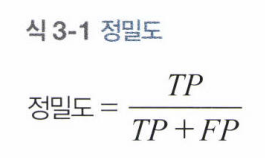

In [26]:
recall_score(y_train_5, y_train_pred)   # 재현율

0.6511713705958311

### 📌 재현율
> 분류기가 정확하게 감지한 양성 샘플의 비율, 민감도, 진짜 양성 비율

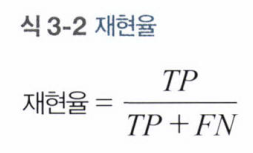

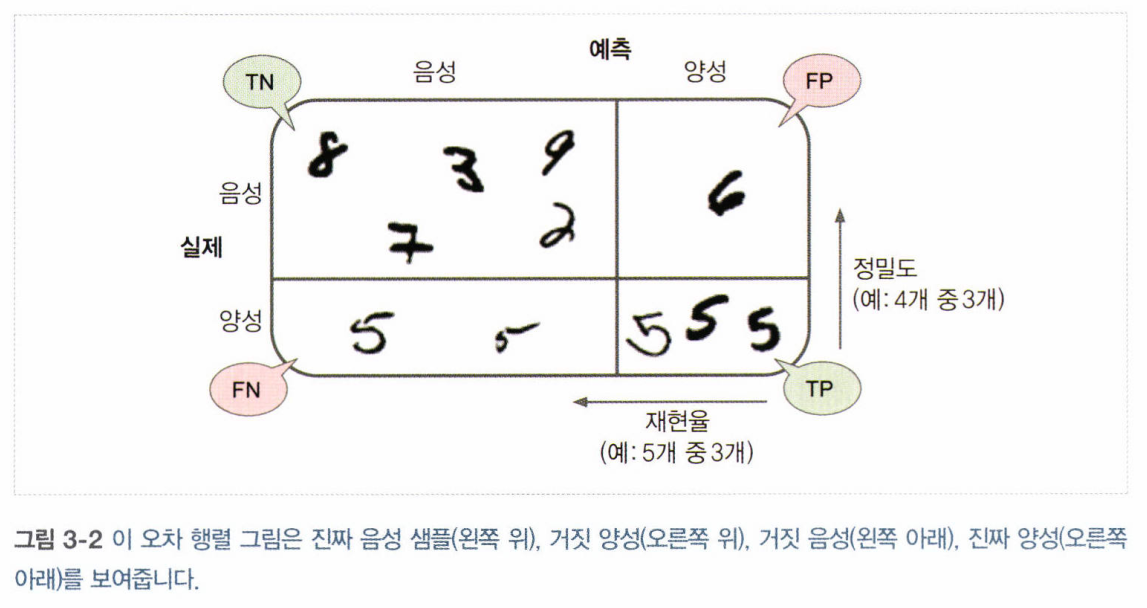

In [27]:
from sklearn.metrics import f1_score  # F1 점수
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 📌 F1 점수
> 정밀도와 재현율의 조화평균 
> 
>정밀도와 재현율이 비슷할 수록 F1 점수가 높음  
상황에 따라 정밀도가 더 중요할 수도, 재현율이 더 중요할 수도  

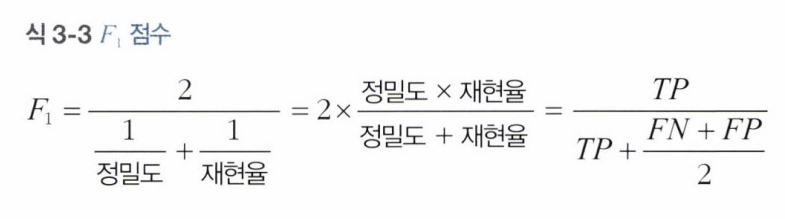

## 3.3.4 정밀도/재현율 트레이드오프

### 📌 정밀도/재현율 트레이드오프
>정밀도와 재현율은 반비례

✔️ SGDClassifier의 분류방식
1. **결정함수**를 사용해 각 샘플의 점수 계산
2. if 샘플 점수 > 임곗값: 양성 클래스  
else: 음성 클래스

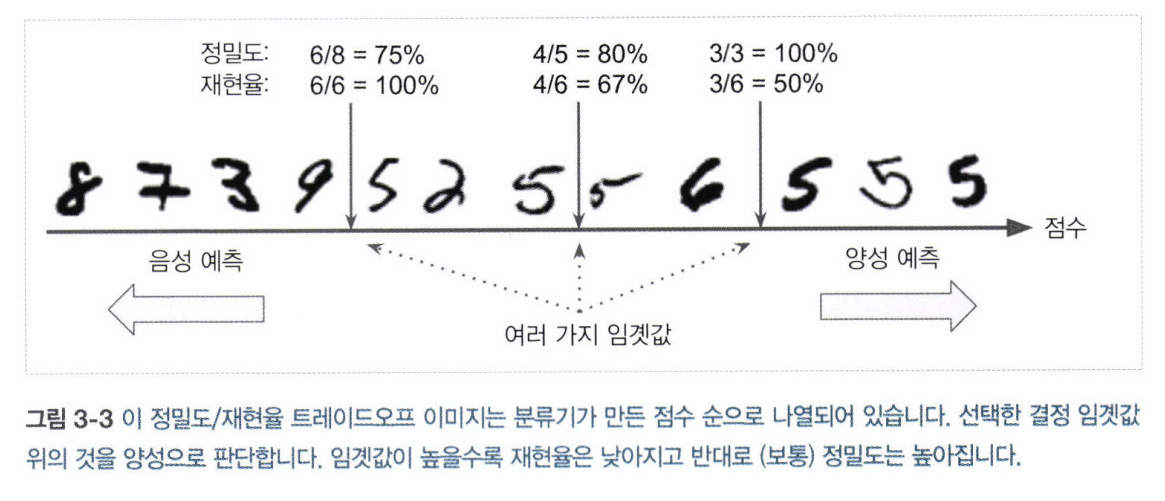

In [28]:
y_scores = sgd_clf.decision_function([some_digit])   # SGDClassifier에서 결정함수를 이용해 some_digit 샘플의 점수 계산해보기
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [29]:
threshold = 0   # 임곗값을 0으로 설정
y_some_digit_pred = (y_scores > threshold)   # 샘플의 점수가 임곗값보다 크다면 True
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000   # 임곗값 높여보기
y_some_digit_pred = (y_scores > threshold)   # 샘플의 점수는 그대로이지만 임곗값보다 작은 상황이 되어서 False
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")   # SGDClassifier에서 결정함수를 이용해 모든 검증 폴드에 대한 결정 점수 반환

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)   # precision_recall_curve() 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산

### 🎯 정밀도/재현율 트레이드오프
>- 결정 임곗값에 대한 정밀도와 재현율
- 재현율에 대한 정밀도 곡선

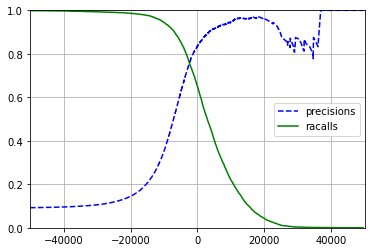

In [48]:
# 결정 임곗값에 대한 정밀도와 재현율
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precisions")
  plt.plot(thresholds, recalls[:-1], "g-", label="racalls")
  plt.xlim([-50000, 50000])
  plt.ylim([0.0, 1.0])
  plt.grid()
  plt.legend(loc="center right")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

✔️ if 목표 정밀도가 90%이라면  
정밀도가 90% 이상이 되는 가장 낮은 임곗값 구함  
-> 가능한 범위에서 재현율을 가장 크게 할 수 있음

In [49]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]   # 정밀도가 90% 이상이 되는 가장 낮은 임곗값 구함 -> 가능한 범위에서 재현율을 가장 크게 할 수 있음
threshold_90_precision

3370.019499143958

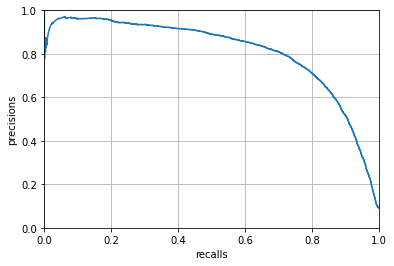

In [50]:
# 재현율에 대한 정밀도 곡선
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls[:-1], precisions[:-1])
  plt.xlabel("recalls")
  plt.ylabel("precisions")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.grid()

plot_precision_vs_recall(precisions, recalls)
plt.show()

✔️ 정밀도가 급격하게 줄어드는 지점의 직전을 정밀도/재현율 트레이트오프로 선택하는 것이 좋음

In [51]:
y_train_pred_90 = (y_scores >= threshold_90_precision)   # 훈련 세트에 대한 예측, 정밀도 90% 이상인 범위에서 가장 낮은 임곗값보다 y_scores가 크다면 True

In [52]:
precision_score(y_train_5, y_train_pred_90)   # 이 예측의 정밀도

0.9000345901072293

In [53]:
recall_score(y_train_5, y_train_pred_90)   # 재현율

0.4799852425751706

## 3.3.5 ROC 곡선

### 📌 ROC 곡선
> `민감도(TPR, 재현율)`에 대한 `1-진짜 음성 비율(TNR)` 그래프  
`거짓 양성 비율(FPR)`에 대한 `진짜 양성 비율(TPR, 재현율)` 

✔️ `거짓 양성 비율(FPR)` == 1 - `진짜 음성 비율(TNR)`  
✔️ `TNR` 특이도  

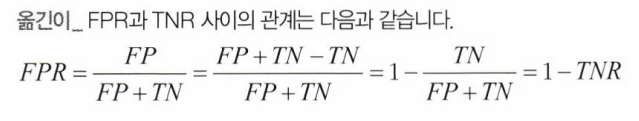

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

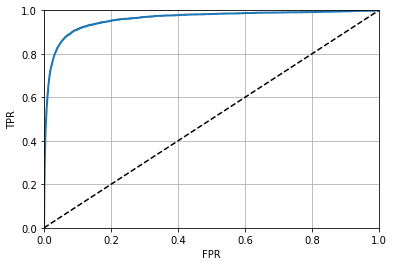

In [59]:
# FPR에 대한 TPR 곡선

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

TPR이 높을수록 FPR이 늘어남 -> 트레이드 오프  
점선(완전한 랜덤 분류기의 ROC곡선)에서 최대한 멀리 떨어져 있어야 좋은 분류기

### 📌 AUC
> 곡선 아래의 면적
>
> 완벽한 분류기: ROC의 AUC가 1  
완전한 랜덤 분류기: ROC의 AUC가 0.5 

In [60]:
# AUC(곡선 아래의 면적) 구하기
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [61]:
# RandomForestClassifier로 훈련시켜 SGDClassifier와 비교해보기
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")   # decision_function()이 없어 predict_proba() 사용

✔️ _predict_proba()_  
>`행` 샘플  
`열` 클래스  
샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [62]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)   # roc_curve() 레이블과 점수(여기서는 클래스 확률)

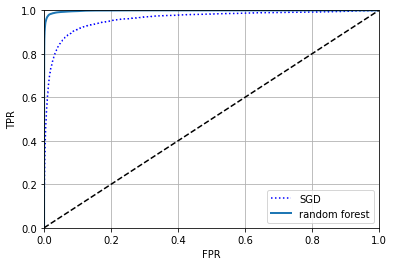

In [63]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음  
AUC가 더 크기 때문

In [64]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

***

# 3.4 다중 분류
### 둘 이상의 클래스를 구별

>- 여러 개의 클래스를직접 처리하는 알고리즘
- 이진 분류만 가능한 알고리즘 -> 여러 개를 사용해 다중 클래스 분류
  - `OvR(OvA)` 특정 숫자 하나만 구분하는 숫자별 이진 분류기를 여러개 훈련
  - `OvO` 2개씩 조합해서 각 숫자의 조합마다 이진 분류기 훈련



### 🎯 SVMClassifier으로 학습해보기
- 이진 분류만 가능한 알고리즘
- 사이킷런이 알아서 OvR or OvO 선택

In [65]:
from sklearn.svm import SVC  
svm_clf = SVC()
svm_clf.fit(X_train, y_train)   #  y_train_5아니고 y_train 써야함
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=int8)

In [66]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores   # 클래스마다 하나씩 점수 반환

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [67]:
np.argmax(some_digit_scores)   # 가장 높은 점수가 예측값

5

In [68]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [69]:
svm_clf.classes_[5]

5

In [70]:
# OvO or OvR을 사용하도록 강제할 때
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

array([5], dtype=int8)

In [71]:
len(ovr_clf.estimators_)

10

### 🎯 SGDClassifier으로 학습해보기
- 직접 다중 클래스로 분류 가능한 알고리즘
- OvR or OvO 적용할 필요 없음

In [72]:
# SGDClassifier는 직접 다중 클래스로 분류할 수 있는 알고리즘이라 OvR 또는 OvO 필요없음
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int8)

In [73]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

🎯 입력 스케일을 조정해서 정확도를 높임

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

***

# 3.5 에러 분석

In [76]:
# 예측 만들고, 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

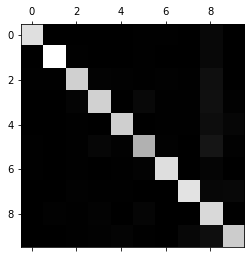

In [77]:
# 오차 행렬 이미지로 변환해서 보기
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

`행` 실제 클래스   
`열` 예측 클래스

In [79]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums   # 에러 비율 = 행렬의 각 값 / 대응되는 클래스의 이미지 개수

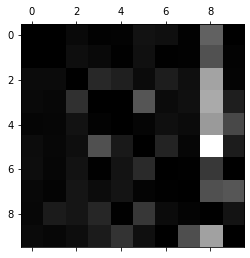

In [80]:
# 다른 항목은 그대로 두고 주대각선만 0으로 채워서 그래프 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

✔️ 8의 `열`이 밝음 -> 많은 이미지가 8로 잘못 분류 되었음  
✔️ 8의 `행`이 어두움 -> 8이 적절히 8로 분류 되었음  
✔️ 3`행`의 5`열`과 5`행`의 3`열`이 밝음 -> 서로 혼동이 많이되었음

***

# 3.6 다중 레이블 분류
### 각 샘플마다 여러개의 클래스를 출력

In [85]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]   # 두 개의 타깃 레이블이 담긴 배열 생성

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [86]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[False,  True]])

In [87]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

***

# 3.7 다중 출력 분류
### 한 레이블이 다중 클래스가 될 수 있도록 일반화

> ex) MNIST는 이미지 하나에 여러 개의 픽셀(다중 레이블)이 있고, 픽셀 강도는 0부터 225까지 가짐(다중 클래스)  
따라서 다중 출력 다중 클래스 분류

In [88]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

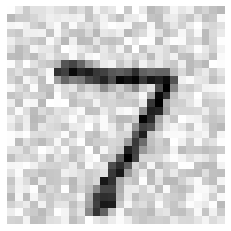

In [97]:
X_test_mod_reshpe = X_test_mod.to_numpy()[0].reshape(28, 28)

plt.imshow(X_test_mod_reshpe, cmap="binary")
plt.axis("off")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


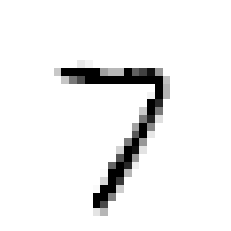

In [100]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.to_numpy()[0]])

clean_digit_reshape = clean_digit.reshape(28, 28)
plt.imshow(clean_digit_reshape, cmap="binary")
plt.axis("off")
plt.show()

***

# 3.8 연습문제